In [13]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import argoverse
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from nuscenes.nuscenes import NuScenes
cuda = torch.cuda.is_available()
device = 'cuda' if True else 'cpu'
print("\nDEVICE: "+ str(device))


DEVICE: cuda


In [14]:
#avm = ArgoverseMap()
#argoverse_forecasting_loader = ArgoverseForecastingLoader('/home/aplesnia/Argoverse')
#nusc = NuScenes(version='v1.0-trainval', dataroot='/home/aplesnia/nuScenes', verbose=True)
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/aplesnia/nuScenes', verbose=True)

In [15]:
class NuScenesDataset(Dataset):
    def __init__(self, split = "trainval", dataroot= '/home/aplesnia/nuScenes'):
        self._nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)
        self._data = []
        self._transforms = transforms.Compose([transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),])
        
        for scene_idx, scene in enumerate(self._nusc.scene):
            sample_token = scene['first_sample_token']
            while sample_token:
                sample = self._nusc.get('sample', sample_token)
                img_data = self._nusc.get('sample_data', sample['data']['CAM_FRONT'])
                self._data.append((dataroot +"/"+img_data['filename'], scene_idx))
                sample_token = sample['next']
                
    def __len__(self):
        return(len(self._data))
               
    def __getitem__(self, idx):
        img_path, scene_idx = self._data[idx]
        img = Image.open(img_path)
        
        if self._transforms:
            img = self._transforms(img)
            
        return(img, scene_idx)

In [16]:
nuscenesdataset = NuScenesDataset()

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.668 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [17]:
nuscenesdataloader = DataLoader(nuscenesdataset, batch_size=256 if cuda else 64 , shuffle=False)

In [18]:
model = models.resnet50(pretrained=True)
model.fc = nn.Identity()
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
for batch_idx, (imgs, scene_idxs) in enumerate(tqdm(nuscenesdataloader)):
    with torch.no_grad():
        imgs = imgs.to(device)
        scene_idxs = scene_idxs.to(device)

        outputs = model(imgs)

        if batch_idx == 0:
            features = torch.empty(0,outputs.shape[1])
            scene_idxs_concate = torch.empty(0)

        features = torch.cat((features,  outputs.cpu()))
        scene_idxs_concate = torch.cat((scene_idxs_concate, scene_idxs.cpu()))

In [36]:
tsne = TSNE(n_components=2).fit_transform(features)

In [37]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

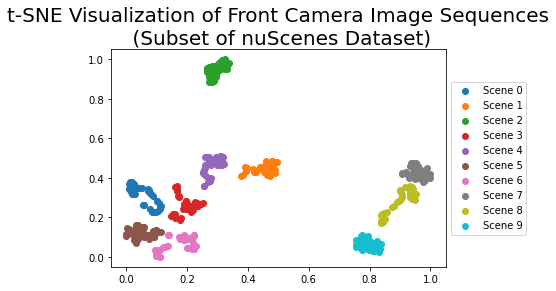

In [38]:
scene_nums = torch.unique(scene_idxs_concate)

# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)

# for every class, we'll add a scatter plot separately
for label in scene_nums:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(scene_idxs_concate) if torch.isclose(l, label)]

    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
    
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, label="Scene "+ str(int(label.item())))

# build a legend using the labels we set previously
plt.title('t-SNE Visualization of Front Camera Image Sequences\n (Subset of nuScenes Dataset)', fontsize=20)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# finally, show the plot
plt.show()

In [26]:
fig.savefig('nuScenes_mini_tsne.png', dpi=300, bbox_inches='tight')